In [3]:
# 필요한 라이브러리 불러오기
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, applications, callbacks

###############################################################################
# 1. 재현성을 위한 랜덤 시드 설정
###############################################################################
seed = 42  # 고정된 랜덤 시드 값
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [4]:
num_classes = 120  # Stanford Dogs dataset number of classes

def normalize_and_resize_img(image, label):
    """Normalize and resize image to (224, 224)."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    """Apply basic augmentation: random flip and brightness adjustment."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    """Convert label to one-hot encoding."""
    label = tf.one_hot(label, num_classes)
    return image, label

def cutmix(image, label):
    """Apply CutMix data augmentation on a batch of images and labels."""
    batch_size = tf.shape(image)[0]
    h, w = tf.shape(image)[1], tf.shape(image)[2]

    idx = tf.random.shuffle(tf.range(batch_size))
    shuffled_image = tf.gather(image, idx)
    shuffled_label = tf.gather(label, idx)

    # Random CutMix parameters
    cut_rate = tf.random.uniform([], 0.3, 0.7)
    cut_h = tf.cast(tf.cast(h, tf.float32)*cut_rate, tf.int32)
    cut_w = tf.cast(tf.cast(w, tf.float32)*cut_rate, tf.int32)
    y1 = tf.random.uniform([], 0, h - cut_h, dtype=tf.int32)
    x1 = tf.random.uniform([], 0, w - cut_w, dtype=tf.int32)
    y2, x2 = y1 + cut_h, x1 + cut_w

    row_coords = tf.range(h)
    col_coords = tf.range(w)
    row_mask = (row_coords >= y1) & (row_coords < y2)
    col_mask = (col_coords >= x1) & (col_coords < x2)
    mask = tf.cast(tf.reshape(row_mask, [1, h, 1, 1]) & tf.reshape(col_mask, [1, 1, w, 1]), tf.float32)
    mask = tf.tile(mask, [batch_size, 1, 1, 1])

    mixed_image = image * (1 - mask) + shuffled_image * mask
    mixed_label = (1 - cut_rate) * label + cut_rate * shuffled_label
    return mixed_image, mixed_label

def mixup(image, label, alpha=0.2):
    """Apply Mixup data augmentation on a batch of images and labels."""
    batch_size = tf.shape(image)[0]

    # Shuffle
    idx = tf.random.shuffle(tf.range(batch_size))
    shuffled_image = tf.gather(image, idx)
    shuffled_label = tf.gather(label, idx)

    # Sample lambda from Beta distribution or uniform. For simplicity, use uniform:
    lam = tf.random.uniform([], 0, 1)  
    # If desired, you can use a Beta distribution (requires tfp):
    # lam = tfp.distributions.Beta(alpha, alpha).sample()

    mixed_image = lam * image + (1 - lam) * shuffled_image
    mixed_label = lam * label + (1 - lam) * shuffled_label
    return mixed_image, mixed_label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    """
    Apply normalization, augmentation, and optionally CutMix or Mixup.
    """
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.map(onehot, num_parallel_calls=2)
    ds = ds.batch(batch_size)

    # Apply CutMix or Mixup if specified
    # If both are True, prioritize CutMix for this example
    if not is_test:
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=2)
        elif with_mixup:
            ds = ds.map(lambda x, y: mixup(x, y), num_parallel_calls=2)

    if not is_test:
        # Repeat and shuffle only for training dataset
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds








In [12]:
# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

# Prepare datasets
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_prepared = apply_normalize_on_dataset(ds_test, is_test=True)


# 각 증강 방식에 대한 데이터셋 결합
# 기본 데이터 + 각 증강 방식별로 결합된 데이터셋
# 이를 통해 각 증강 방식이 학습 성능에 미치는 영향을 비교 가능

ds_train_combined_aug = ds_train_no_aug.concatenate(ds_train_aug)
ds_train_combined_cutmix = ds_train_no_aug.concatenate(ds_train_cutmix)
ds_train_combined_mixup = ds_train_no_aug.concatenate(ds_train_mixup)


In [57]:
# 초기 코드 안되어 수정

# ############################################################
# # 원본 테스트셋 클래스 분포 시각화
# ############################################################
# class_count_test = get_class_distribution(ds_test)
# class_count_bar(class_count_test, "Original Test Set Class Distribution")

# ############################################################
# # 테스트셋에서 클래스별 동일 개수 추출
# # 각 클래스별 최소 샘플 수를 찾은 뒤, 그 수만큼만 샘플링
# ############################################################
# min_count = min(class_count_test)

# # 각 클래스를 별도 tf.data로 필터링 후 min_count만큼 추출
# def filter_by_class(ds, class_index):
#     return ds.filter(lambda img, lbl: tf.equal(lbl, class_index))

# # 균형 잡힌 테스트셋 생성
# balanced_datasets = []
# for c in range(num_classes):
#     ds_c = filter_by_class(ds_test, c)
#     # take()를 사용해 min_count 개만큼만 가져오기
#     ds_c = ds_c.take(min_count)
#     balanced_datasets.append(ds_c)

# ds_test_balanced = balanced_datasets[0]
# for c_ds in balanced_datasets[1:]:
#     ds_test_balanced = ds_test_balanced.concatenate(c_ds)

# # 섞어서 클래스 순서 균등화
# ds_test_balanced = ds_test_balanced.shuffle(buffer_size=min_count*num_classes, seed=42)

# # 균형 잡힌 테스트셋 클래스 분포 확인
# balanced_count = get_class_distribution(ds_test_balanced)
# class_count_bar(balanced_count, "Balanced Test Set Class Distribution")


NameError: name 'class_count_bar' is not defined

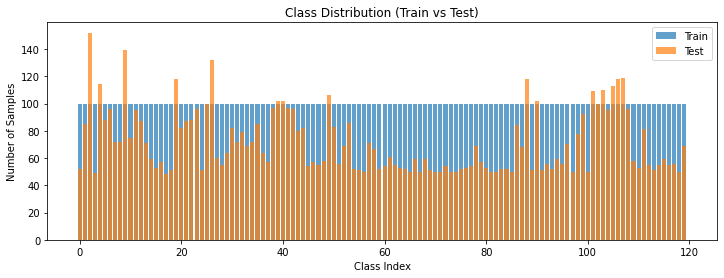

In [56]:
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

# ---------------------------------------------------------------------------------------
# (1) 클래스 분포 확인
# 원본 학습 데이터셋에서 각 클래스(견종)별 이미지 수를 계산하고, 이를 바 차트로 시각화합니다.
# ---------------------------------------------------------------------------------------

def get_class_distribution(ds):
    """
    데이터셋에서 클래스별 개수를 세는 함수
    Args:
        ds: (이미지, 라벨) 형태의 데이터셋
    Returns:
        class_count: 클래스 인덱스별 샘플 수를 담은 리스트
    """
    class_count = [0]*num_classes
    for _, label in ds:
        class_count[label.numpy()] += 1
    return class_count

class_count_train = get_class_distribution(ds_train)
class_count_test = get_class_distribution(ds_test)

# 클래스 분포 시각화
plt.figure(figsize=(12, 4))
plt.bar(range(num_classes), class_count_train, alpha=0.7, label='Train')
plt.bar(range(num_classes), class_count_test, alpha=0.7, label='Test')
plt.title("Class Distribution (Train vs Test)")
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()

In [5]:
###############################################################################
# 데이터셋에서 증강 방식 시각화
###############################################################################

def visualize_augmentations(ds, num_images=5):
    """
    데이터셋에서 여러 증강 방식을 시각화합니다.
    Args:
        ds: TensorFlow 데이터셋.
        num_images: 시각화할 이미지 수.
    """
    import matplotlib.pyplot as plt

    # 5개의 서로 다른 이미지를 가져오기
    ds_vis = ds.take(num_images).batch(num_images)
    images_list, labels_list = [], []

    for images, labels in ds_vis:
        images_list = images  # 5개의 서로 다른 이미지를 저장
        labels_list = tf.cast(labels, tf.float32)  # 라벨을 float32로 변환

    # 증강 방식별로 동일한 이미지를 사용
    plt.figure(figsize=(15, 15))
    for i, (title, augment_func) in enumerate([
        ("Original", None),
        ("Basic Augmentation", augment),
        ("CutMix", cutmix),
        ("Mixup", mixup)
    ]):
        augmented_images = images_list
        augmented_labels = labels_list

        if augment_func == augment:
            augmented_images, augmented_labels = augment(augmented_images, augmented_labels)
        elif augment_func == cutmix:
            augmented_images, augmented_labels = cutmix(augmented_images, augmented_labels)
        elif augment_func == mixup:
            augmented_images, augmented_labels = mixup(augmented_images, augmented_labels)

        for j in range(num_images):
            plt.subplot(4, num_images, i * num_images + j + 1)
            plt.imshow(augmented_images[j].numpy())
            plt.axis('off')
            if j == 0:
                plt.ylabel(title, fontsize=12)
            plt.title(title if j == 0 else "", fontsize=10, loc='center')
    plt.show()

# 기본 증강 함수
# 기본 증강에 더 강한 변화를 추가하여 차이를 명확히 함

def augment(image, label):
    """
    기본 증강 함수: 더 강한 변형을 적용하여 차이점을 명확히 함.
    Args:
        image: 입력 이미지.
        label: 이미지에 대한 라벨.
    Returns:
        변형된 이미지와 라벨.
    """
    image = tf.image.random_flip_left_right(image)  # 수평 뒤집기
    image = tf.image.random_brightness(image, max_delta=0.5)  # 밝기 조정 (더 큰 max_delta)
    image = tf.image.random_contrast(image, lower=0.5, upper=2.0)  # 대비 조정
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)  # 채도 조정
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # 랜덤 회전
    image = tf.clip_by_value(image, 0, 1)  # 값 클리핑 (0~1 사이로 제한)
    return image, label

# 원본 데이터 시각화
# 5개의 서로 다른 이미지를 선택하여 증강 방식 비교
ds_sample = ds_train.map(normalize_and_resize_img).take(5)  # 5개의 서로 다른 이미지를 선택

# 시각화 호출
print("\n[Augmentation Visualization]")
visualize_augmentations(ds_sample, num_images=5)

NameError: name 'ds_train' is not defined

In [6]:
def create_resnet50_model():
    """Create a ResNet50 model."""
    base_model = applications.ResNet50(include_top=False, 
                                       weights='imagenet', 
                                       input_shape=(224, 224, 3), 
                                       pooling='avg')
    model = models.Sequential([
        base_model,
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def train_model(model, train_ds, steps_per_epoch, epochs=1):
    """Train the model."""
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_ds, 
                        validation_data=ds_test_prepared, 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs)
    return history

# Assume we know the total number of training images for steps_per_epoch
# Stanford Dogs has 12020 training images
train_images = ds_info.splits['train'].num_examples
batch_size = 16
steps_per_epoch = train_images // batch_size



In [11]:
# Train different models with different augmentation strategies
model_no_aug = create_resnet50_model()
model_aug = create_resnet50_model()
model_cutmix = create_resnet50_model()
model_mixup = create_resnet50_model()



In [12]:
#모델 test
history_no_aug = train_model(model_no_aug, ds_train_no_aug, steps_per_epoch, epochs=1)
history_aug = train_model(model_aug, ds_train_combined_aug, steps_per_epoch, epochs=1)
history_cutmix = train_model(model_cutmix, ds_train_combined_cutmix, steps_per_epoch, epochs=1)
history_mixup = train_model(model_mixup, ds_train_combined_mixup, steps_per_epoch, epochs=1)

750/750 [==============================] - 168s 214ms/step - loss: 4.7849 - accuracy: 0.0157 - val_loss: 4.7798 - val_accuracy: 0.0071


In [13]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 경로 설정
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 모델 저장 콜백 함수 생성
def get_checkpoint_callback(model_name):
    """
    모델 학습 중 최적의 지점을 저장하는 체크포인트 콜백을 생성합니다.
    Args:
        model_name: 저장할 모델 파일 이름 (확장자는 자동으로 h5 추가됨).
    Returns:
        ModelCheckpoint 콜백.
    """
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}.h5")
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,  # 저장 경로
        monitor='val_accuracy',  # 검증 정확도를 기준으로 저장
        save_best_only=True,  # 최적 모델만 저장
        save_weights_only=False,  # 전체 모델 저장
        mode='max',  # 최대화 기준 (검증 정확도)
        verbose=1  # 저장 시 메시지 출력
    )
    return checkpoint_callback

# EarlyStopping with same criteria for all
es = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# 모델 학습 함수 수정: 체크포인트만 추가
def train_model_with_checkpoint(model, train_ds, steps_per_epoch, epochs=50, model_name="model"):
    """
    모델을 학습하며, 최적의 지점을 체크포인트로 저장합니다.
    Args:
        model: 학습할 모델.
        train_ds: 학습 데이터셋.
        steps_per_epoch: 한 epoch 당 실행할 step 수.
        epochs: 학습 반복 횟수.
        model_name: 체크포인트 파일 이름.
    Returns:
        학습 히스토리.
    """
    # 체크포인트 콜백 생성
    checkpoint_callback = get_checkpoint_callback(model_name)

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        train_ds,
        validation_data=ds_test_prepared,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[es],  # EarlyStopping 추가
        verbose=1
    )
    return history



In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# 체크포인트를 저장할 디렉토리 설정
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def get_checkpoint_callback(model_name):
    """
    모델 학습 중 검증 정확도가 가장 높은 지점에서의 모델 상태를 저장하는 콜백을 생성합니다.
    Args:
        model_name: 저장할 모델 파일명(확장자 h5는 자동으로 추가됩니다).
    Returns:
        ModelCheckpoint 콜백 객체.
    """
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}.h5")
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,        # 모델 저장 경로
        monitor='val_accuracy',          # 검증 정확도를 모니터링
        save_best_only=True,            # 가장 좋은 모델만 저장
        save_weights_only=False,         # 모델 전체 저장
        mode='max',                     # 모니터링 값의 최대값을 기준으로 저장
        verbose=1                       # 모델 저장 시 메시지 출력
    )
    return checkpoint_callback

# 모든 모델에 동일한 EarlyStopping 기준 적용: 검증 정확도가 10 에폭 동안 개선되지 않으면 학습 중단
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

def train_model_with_checkpoint(model, train_ds, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model"):
    """
    모델을 학습하면서 검증 정확도가 최고치일 때 모델을 체크포인트로 저장합니다.
    Args:
        model: 학습할 모델 객체.
        train_ds: 학습 데이터셋.
        steps_per_epoch: 한 에폭 당 수행할 스텝 수.
        ds_test_prepared: 검증(또는 테스트)용 전처리 완료 데이터셋.
        epochs: 총 학습할 에폭 수.
        model_name: 저장할 모델의 기본 파일명(확장자 제외).
    Returns:
        학습 히스토리(history) 객체.
    """
    checkpoint_callback = get_checkpoint_callback(model_name)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_ds,
        validation_data=ds_test_prepared,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[es, checkpoint_callback],  # EarlyStopping, Checkpoint 콜백 추가
        verbose=1
    )
    return history

def load_and_train_model_if_exists(model_fn, train_ds, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model"):
    """
    기존에 학습된 모델이 존재하면 해당 모델을 불러와서 학습을 이어갑니다.
    없으면 새로운 모델을 생성하고 처음부터 학습합니다.
    Args:
        model_fn: 새로운 모델을 생성하는 함수. 예: create_resnet50_model
        train_ds: 학습 데이터셋.
        steps_per_epoch: 한 에폭 당 스텝 수.
        ds_test_prepared: 검증(또는 테스트)용 전처리 완료 데이터셋.
        epochs: 총 학습 에폭 수.
        model_name: 모델 체크포인트 파일명(확장자 제외).
    Returns:
        학습 히스토리(history) 객체.
    """
    model_path = os.path.join(checkpoint_dir, f"{model_name}.h5")

    if os.path.exists(model_path):
        print(f"'{model_path}' 모델 파일을 발견하였습니다. 해당 모델을 로드하고 학습을 이어갑니다.")
        model = load_model(model_path)
    else:
        print("기존 모델 파일을 찾지 못했습니다. 새로운 모델을 생성하고 학습을 시작합니다.")
        model = model_fn()

    history = train_model_with_checkpoint(
        model=model,
        train_ds=train_ds,
        steps_per_epoch=steps_per_epoch,
        ds_test_prepared=ds_test_prepared,
        epochs=epochs,
        model_name=model_name
    )
    return history


In [19]:
# ds_test_prepared 변수를 이미 준비했다고 가정
history_no_aug = load_and_train_model_if_exists(model_no_aug, ds_train_no_aug, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model_no_aug")
history_aug = load_and_train_model_if_exists(model_aug, ds_train_combined_aug, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model_aug")
history_cutmix = load_and_train_model_if_exists(model_cutmix, ds_train_combined_cutmix, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model_cutmix")
history_mixup = load_and_train_model_if_exists(model_mixup, ds_train_combined_mixup, steps_per_epoch, ds_test_prepared, epochs=50, model_name="model_mixup")


'./checkpoints/model_no_aug.h5' 모델 파일을 발견하였습니다. 해당 모델을 로드하고 학습을 이어갑니다.
Epoch 1/50
750/750 [==============================] - 166s 212ms/step - loss: 3.1347 - accuracy: 0.2012 - val_loss: 4.1172 - val_accuracy: 0.1167

Epoch 00001: val_accuracy improved from -inf to 0.11667, saving model to ./checkpoints/model_no_aug.h5
Epoch 2/50
750/750 [==============================] - 159s 212ms/step - loss: 2.6598 - accuracy: 0.2895 - val_loss: 3.7090 - val_accuracy: 0.1526

Epoch 00002: val_accuracy improved from 0.11667 to 0.15256, saving model to ./checkpoints/model_no_aug.h5
Epoch 3/50
750/750 [==============================] - 159s 212ms/step - loss: 2.1997 - accuracy: 0.3965 - val_loss: 4.7699 - val_accuracy: 0.1228

Epoch 00003: val_accuracy did not improve from 0.15256
Epoch 4/50
750/750 [==============================] - 159s 213ms/step - loss: 1.7065 - accuracy: 0.5021 - val_loss: 3.1963 - val_accuracy: 0.2118

Epoch 00004: val_accuracy improved from 0.15256 to 0.21177, saving model to .

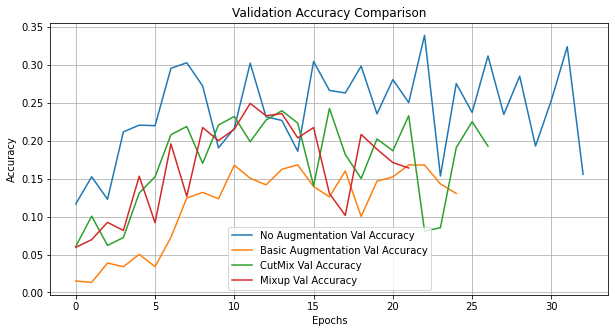

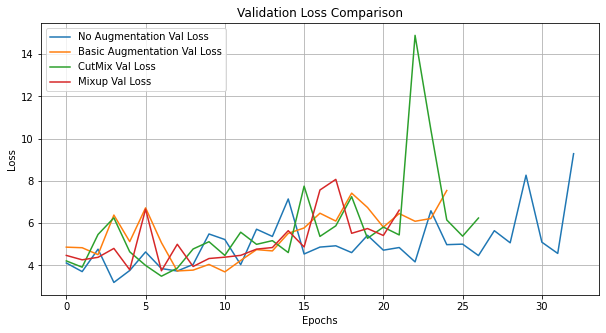

In [20]:
def plot_histories(histories, labels):
    plt.figure(figsize=(10, 5))
    for hist, lbl in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'{lbl} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    for hist, lbl in zip(histories, labels):
        plt.plot(hist.history['val_loss'], label=f'{lbl} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories(
    [history_no_aug, history_aug, history_cutmix, history_mixup],
    ['No Augmentation', 'Basic Augmentation', 'CutMix', 'Mixup']
)

In [52]:
# def extract_highest_accuracy_from_history(history_dict):
#     """
#     주어진 학습 기록에서 각 모델의 최고 검증 정확도를 반환합니다.
#     Args:
#         history_dict: 각 모델의 학습 기록 딕셔너리. {"model_name": history 객체} 형식.
#     Returns:
#         각 모델의 최고 검증 정확도 딕셔너리.
#     """
#     max_accuracies = {}
#     for model_name, history in history_dict.items():
#         max_val_acc = max(history_dict.history["val_accuracy"])
#         max_accuracies[model_name] = max_val_acc
#         print(f"{model_name} 최고 검증 정확도: {max_val_acc}")
#     return max_accuracies




def extract_highest_accuracy_from_history(history_dict):
    """
    주어진 학습 기록에서 각 모델의 최고 검증 정확도를 반환합니다.
    Args:
        history_dict: 각 모델의 학습 기록 딕셔너리. {"model_name": history 객체} 형식.
    Returns:
        각 모델의 최고 검증 정확도 딕셔너리.
        
    """
    
    
    max_accuracies = {}
    for model_name, history in history_dict.items():
        if "val_accuracy" in history.history:  # "val_accuracy" 존재 여부 확인
            max_val_acc = max(history.history["val_accuracy"])
            max_accuracies[model_name] = max_val_acc
            print(f"{model_name} 최고 검증 정확도: {max_val_acc}")
        else:
            print(f"Warning: {model_name} does not contain 'val_accuracy'. Skipping.")
            max_accuracies[model_name] = None
    return max_accuracies

In [53]:
history_dict = {
    "No Augmentation": history_no_aug,
    "Basic Augmentation": history_aug,
    "CutMix": history_cutmix,
    "MixUp":history_mixup
}

extract_highest_accuracy_from_history(history_dict)


No Augmentation 최고 검증 정확도: 0.3390443027019501
Basic Augmentation 최고 검증 정확도: 0.16818182170391083
CutMix 최고 검증 정확도: 0.2426573485136032
MixUp 최고 검증 정확도: 0.24930070340633392


{'No Augmentation': 0.3390443027019501,
 'Basic Augmentation': 0.16818182170391083,
 'CutMix': 0.2426573485136032,
 'MixUp': 0.24930070340633392}

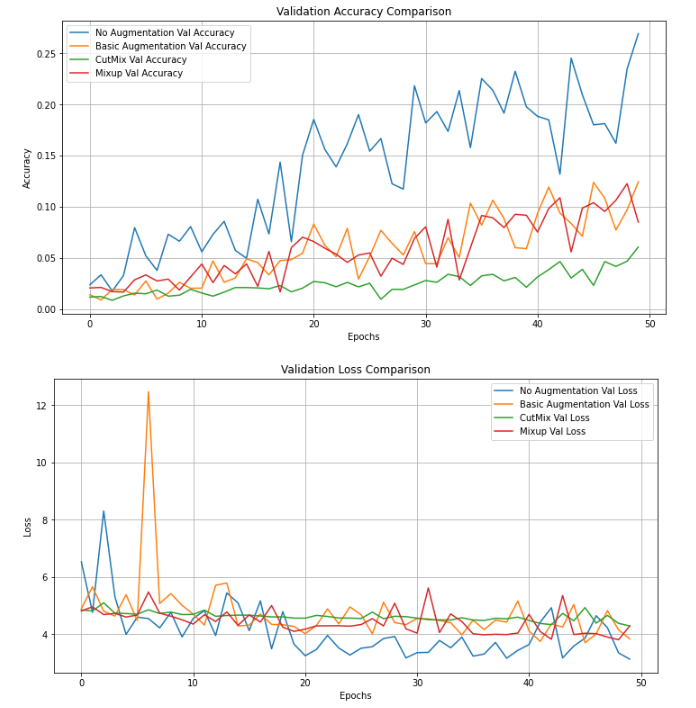

기본 실험에서 augmentation 성능이 낮게 나와 기본데이터 + augmentation로 실험 진행


기본 실험에서 50에폭으로 실험을 진행하였으나, cutmix 논문에서는 70에폭 이상에서 모델 성능 향상을 볼 수 있어서
팀원들과 나누어 각각으 모델별로 실험 진행(추후 업데이트 예정)

이번 실험과 관련된 논문이 있어 참고

Affinity와 Diversity 지표 도입: 데이터 증강이 모델 일반화에 미치는 영향을 정량화하기 위해 두 가지 해석 가능하고 계산이 용이한 지표인 Affinity와 Diversity를 소개

Affinity: 증강된 데이터가 원본 데이터 분포와 얼마나 유사한지를 측정

Diversity: 증강된 데이터가 모델에 제공하는 다양성을 평가.

두 지표의 공동 최적화 중요성: 모델의 성능은 Affinity나 Diversity 중 하나만으로는 충분히 예측되지 않으며, 두 지표를 함께 최적화할 때 가장 우수한 성능을 발휘함을 발견


Affinity와 Diversity는 데이터 증강의 효과를 평가하는 두 가지 주요 지표.
Affinity는 증강된 데이터가 원본 데이터 분포와 얼마나 유사한지를 나타내며, 값이 높을수록 유사성이 큽니다.
Diversity는 증강된 데이터가 모델에 제공하는 다양성을 측정하며, 값이 높을수록 데이터의 다양성이 증가합니다.
이 실험에서는 증강 적용 확률이 증가할수록 Affinity는 감소하고, Diversity는 증가하는 경향을 보였습니다.
그러나 테스트 정확도는 단순히 Affinity나 Diversity 중 하나에만 의존하지 않으며, 두 지표의 균형이 중요함을 보여줍니다.
즉, 너무 낮은 Affinity는 모델이 원본 데이터의 특징을 학습하는 데 방해가 되고, 너무 높은 Diversity는 모델이 과도한 변형에 노출되어 일반화 성능이 저하될 수 있습니다.
따라서, 테스트 정확도를 최적화하려면 Affinity와 Diversity의 균형을 고려한 중간 정도의 증강 적용이 필요합니다.
결론:

데이터 증강 시 Affinity와 Diversity의 균형을 고려하여 증강 강도와 적용 확률을 조절하는 것이 모델의 일반화 성능 향상에 중요합니다.
이러한 균형을 통해 모델이 원본 데이터의 특징을 유지하면서도 다양한 데이터에 대한 학습을 통해 성능을 극대화할 수 있습니다.
참고문헌:

Gontijo-Lopes, R., Smullin, S. J., Cubuk, E. D., & Dyer, E. (2020). Affinity and Diversity: Quantifying Mechanisms of Data Augmentation. arXiv preprint arXiv:2002.08973. https://arxiv.org/abs/2002.08973
